Authors:
<br />
Arsh Lalani, Faculty of Engineering, Western University 
<br />
Andrew Harrop, Faculty of Engineering, Western University

External Libraries:

In [1]:
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16, preprocess_input
import cv2
import numpy as np
import imutils

import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator


Internal Libraries:

In [2]:
# Internal libraries:
from load_images import load_images

from preprocessing import multiple_dataset_conversion
from preprocessing import crop_images
from preprocessing import preprocess_images
from preprocessing import augment_image_set

from plotting import plot_image_classes
from plotting import plot_cnn_history
from plotting import plot_image
from plotting import plot_augmented

from Models.VGG16 import build_cnn
from Models.VGG16 import train_cnn


Load images from the dataset

In [3]:
dataset_1_tumor_images, dataset_1_normal_images = load_images(1)
dataset_2_tumor_images, dataset_2_normal_images = load_images(2)

Plot random images:

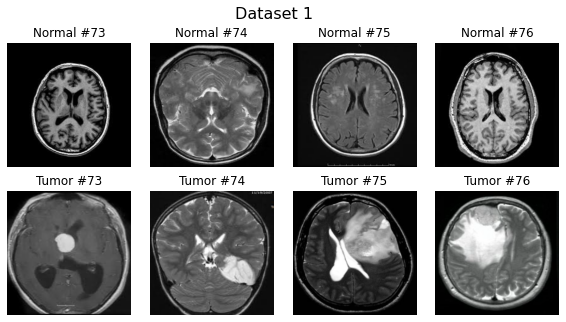

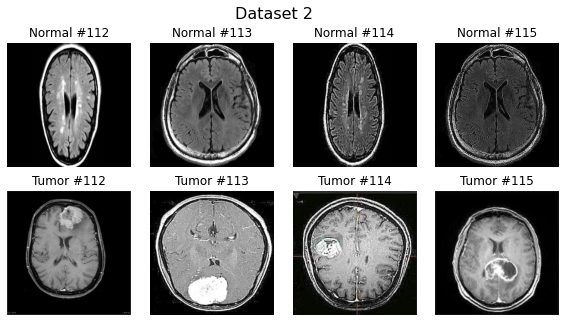

In [4]:
plot_image_classes(dataset_1_normal_images, dataset_1_tumor_images, n_images=4, title="Dataset 1")
plot_image_classes(dataset_2_normal_images, dataset_2_tumor_images, n_images=4, title="Dataset 2")

Crop the brain into the full view

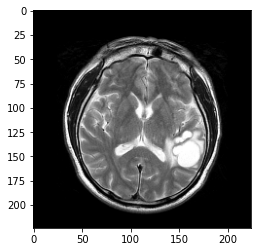

/Users/andrew/Desktop/School/CS4442/Final/CodingEnv/Advanced-AI-Thesis/preprocessing.py:111: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(cropped_images)


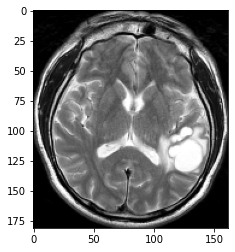

In [5]:
plot_image(dataset_1_tumor_images[4])
dataset_1_tumor_images_proc = crop_images(dataset_1_tumor_images)
dataset_1_normal_images_proc = crop_images(dataset_1_normal_images)
dataset_2_tumor_images_proc = crop_images(dataset_2_tumor_images)
dataset_2_normal_images_proc = crop_images(dataset_2_normal_images)

test_image = dataset_1_tumor_images_proc[4]
plot_image(test_image)

In [6]:
dataset_1_normal_images_proc = preprocess_images(dataset_1_normal_images_proc, (224, 224))
dataset_1_tumor_images_proc = preprocess_images(dataset_1_tumor_images_proc, (224, 224))
dataset_2_normal_images_proc = preprocess_images(dataset_2_normal_images_proc, (224, 224))
dataset_2_tumor_images_proc = preprocess_images(dataset_2_tumor_images_proc, (224, 224))

Split the datasets. The light dataset contains many fewer images, which is convenient for testing preliminary models.

In [7]:
X, Y = multiple_dataset_conversion(yes = [dataset_1_normal_images_proc, dataset_2_normal_images_proc], no = [dataset_1_tumor_images_proc, dataset_2_tumor_images_proc])
X_light, Y_light = multiple_dataset_conversion(yes = [dataset_1_normal_images], no = [dataset_1_tumor_images])

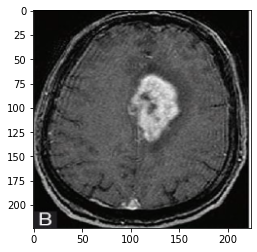

In [8]:
# Sp;it into train, test, and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5, random_state=42, stratify=Y_test)

X_light_train, X_light_test, Y_light_train, Y_light_test = train_test_split(X_light, Y_light, test_size=0.2, random_state=42, stratify=Y_light)
X_light_test, X_light_val, Y_light_test, Y_light_val = train_test_split(X_light_test, Y_light_test, test_size=0.5, random_state=42, stratify=Y_light_test)

plot_image(X_light_train[0])

Preform some data augmentation on the training data

In [9]:
example_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


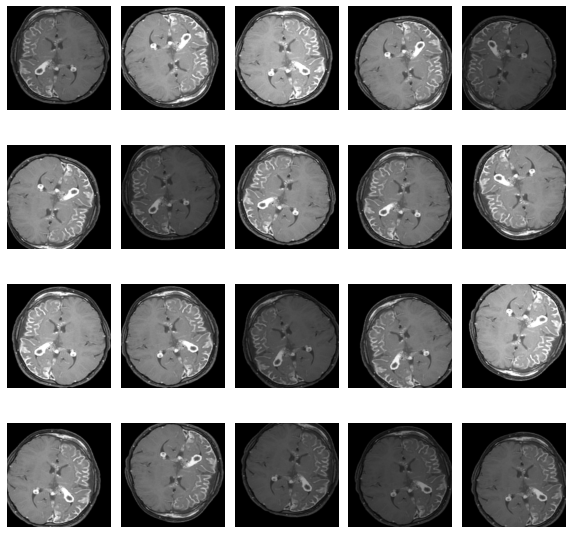

In [10]:
plot_augmented(X_light_train[5], example_datagen)

In [11]:
# Applting augmentation to the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1./255,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)




        

In [14]:
X_train_augment, Y_train_augment = augment_image_set(X_train, Y_train, train_datagen)

In [15]:
X_test_augment, Y_test_augment = augment_image_set(X_test, Y_test, test_datagen)

In [16]:
X_val_augment, Y_val_augment = augment_image_set(X_val, Y_val, test_datagen)

In [17]:
X_train_light_augment, Y_train_light_augment = augment_image_set(X_light_train, Y_light_train, train_datagen)

In [18]:
X_test_light_augment, Y_test_light_augment = augment_image_set(X_light_test, Y_light_test, test_datagen)

In [19]:
X_val_light_augment, Y_val_light_augment = augment_image_set(X_light_val, Y_light_val, test_datagen)

Data is now ready to be used for training.